In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bukusu-augmented-ds/bukusu_augmented.csv
/kaggle/input/augmented-dataset/augmented_dataset.csv
/kaggle/input/marachi-updated/Marachi_Latest_dataset.csv
/kaggle/input/bukusulatest/Bukusu_Latest_dataset.csv


In [2]:
import numpy as np
import pandas as pd
!pip install Keras-Preprocessing
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input,LSTM, Dense, Embedding, Attention
from keras.layers import TimeDistributed, RepeatVector,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import re
import string
from unicodedata import normalize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


2024-08-03 13:02:50.061636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 13:02:50.061759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 13:02:50.197401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import csv

In [5]:
df = pd.read_csv(r'/kaggle/input/marachi-updated/Marachi_Latest_dataset.csv')
df.head()

,Original,Translation
0,isafari eyokhutsia khubebusi bange mombasa,safari ya kuenda kwa wazazi wangu mombasa
1,yalio inyanga ndala eya abebusi bange bananga ...,kulikuwa na siku wazazi wangu walinialika nian...
2,olwa inyanga eyo yola ndetayarisia evilai nga ...,hiyo siku ilipowadia nijitayarisha vizuri nika...
3,lwahuola ekhoere obukula omutoka kwetsa nekwit...,tulipofika nilipofaa kuabiri gari gari lilikuj...
4,obulayi olwa khwanza oluchendo khwenukha obula...,tulipoanza safari tulianza salama na tulipofik...


In [6]:
#Pre-processing function
def preprocess_text(text):
    # normalize unicode characters
    text = normalize('NFD',text).encode("ascii","ignore")
    text = text.decode("UTF-8")
    # convert to string
    text = str(text)
    # convert to lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove non-printable chars from text
    re_print = re.compile('[^%s]'% re.escape(string.printable))
    text = re_print.sub('',text)
    # remove numbers
    text = re.sub(r'[\d]+','',text)
    # remove multiple spaces
    text = ' '.join(text.split())
    return text

In [7]:
#Apply pre-processing
df_copy = df.copy()
df_copy['Original'] = df_copy.loc[:,'Original'].apply(
    lambda x:preprocess_text(x))
df_copy['Translation'] = df_copy.loc[:,'Translation'].apply(
    lambda x:preprocess_text(x))
df_copy.head()

,Original,Translation
0,isafari eyokhutsia khubebusi bange mombasa,safari ya kuenda kwa wazazi wangu mombasa
1,yalio inyanga ndala eya abebusi bange bananga ...,kulikuwa na siku wazazi wangu walinialika nian...
2,olwa inyanga eyo yola ndetayarisia evilai nga ...,hiyo siku ilipowadia nijitayarisha vizuri nika...
3,lwahuola ekhoere obukula omutoka kwetsa nekwit...,tulipofika nilipofaa kuabiri gari gari lilikuj...
4,obulayi olwa khwanza oluchendo khwenukha obula...,tulipoanza safari tulianza salama na tulipofik...


In [8]:
def tokenize(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    return tokenizer

In [10]:
# Luhya tokenizer

eng_tokenizer = tokenize(df_copy['Original'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# Swahili tokenizer
fr_tokenizer = tokenize(df_copy['Translation'])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

# Sequences
seq_eng = eng_tokenizer.texts_to_sequences(df_copy['Original'])
seq_fr = fr_tokenizer.texts_to_sequences(df_copy['Translation'])

# Padding
max_length = max([len(seq) for seq in seq_eng + seq_fr])
seq_eng_final = pad_sequences(seq_eng,maxlen=max_length,padding="post")
seq_fr_final = pad_sequences(seq_fr,maxlen=max_length,padding="post")

print("Bukusu Vocab Size:",eng_vocab_size)
print("Swahili Vocab Size:",fr_vocab_size)
print("Maximum length of sequences:",max_length)

Bukusu Vocab Size: 8249
Swahili Vocab Size: 5203
Maximum length of sequences: 80


In [11]:
# Define model architecture
def create_model(eng_vocab_size, fr_vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(eng_vocab_size, 256, input_length=max_length, mask_zero=True))
    model.add(Bidirectional(LSTM(256)))
    model.add(RepeatVector(max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
print(model.summary())

NameError: name 'model' is not defined

In [16]:
plot_model(model,to_file="model.png",show_shapes=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [13]:
# K-Fold Cross Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_no = 1

# To accumulate metrics for plotting
all_loss = []
all_val_loss = []
all_accuracy = []
all_val_accuracy = []

all_precision = []
all_recall = []
all_f1 = []

In [14]:
for train_index, test_index in kf.split(seq_eng_final):
    print(f'Fold {fold_no}...')
    
    X_train, X_val = seq_eng_final[train_index], seq_eng_final[test_index]
    y_train, y_val = seq_fr_final[train_index], seq_fr_final[test_index]
    
    model = create_model(eng_vocab_size, fr_vocab_size, max_length)
    
    # Convert target data to categorical (one-hot encoded)
    y_train_cat = np.expand_dims(y_train, -1)
    y_val_cat = np.expand_dims(y_val, -1)
    
    history = model.fit(X_train, y_train_cat, epochs=30, batch_size=32, validation_data=(X_val, y_val_cat))
    
    # Evaluate the model
    scores = model.evaluate(X_val, y_val_cat, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100}%')
    
    #Added code
    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=-1)
    
    # Flatten the arrays for metric calculation
    y_val_flat = y_val.flatten()
    y_val_pred_flat = y_val_pred_classes.flatten()
    
    # Calculate classification matrix metrics
    precision = precision_score(y_val_flat, y_val_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_val_flat, y_val_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_val_flat, y_val_pred_flat, average='macro', zero_division=0)
    
    print(f'Precision for fold {fold_no}: {precision * 100:.4f}')
    print(f'Recall for fold {fold_no}: {recall * 100:.4f}')
    print(f'F1 Score for fold {fold_no}: {f1 * 100:.4f}')
    
    # Append history for averaging later
    all_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])
    all_accuracy.append(history.history['accuracy'])
    all_val_accuracy.append(history.history['val_accuracy'])
    
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
       
    fold_no += 1

Fold 1...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.8338 - loss: 1.8310 - val_accuracy: 0.8553 - val_loss: 1.0473
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8525 - loss: 1.0536 - val_accuracy: 0.8569 - val_loss: 0.9783
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.8550 - loss: 0.9614 - val_accuracy: 0.8588 - val_loss: 0.8904
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.8560 - loss: 0.8760 - val_accuracy: 0.8601 - val_loss: 0.7995
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8588 - loss: 0.7686 - val_accuracy: 0.8642 - val_loss: 0.7018
Epoch 6/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8667 - loss: 0.6567 - val_accuracy: 0.8711 - val_loss: 0.6153
Epoch 7/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8728 - loss: 0.5750 - val_accuracy: 0.8762 - val_loss: 0.5487
Epoch 8/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8779 - loss: 0.5122 - 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


557/557 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accuracy: 0.8367 - loss: 1.7918 - val_accuracy: 0.8505 - val_loss: 1.0763
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8543 - loss: 1.0393 - val_accuracy: 0.8534 - val_loss: 0.9964
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8557 - loss: 0.9633 - val_accuracy: 0.8546 - val_loss: 0.9158
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8555 - loss: 0.8789 - val_accuracy: 0.8565 - val_loss: 0.8308
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8590 - loss: 0.7762 - val_accuracy: 0.8604 - val_loss: 0.7343
Epoch 6/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8643 - loss: 0.6820 - val_accuracy: 0.8645 - val_loss: 0.6619
Epoch 7/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8705 - loss: 0.6025 - val_accuracy: 0.8717 - val_loss: 0.5865
Epoch 8/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8783 - loss: 0.5265 - val_accurac

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


557/557 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accuracy: 0.8385 - loss: 1.7924 - val_accuracy: 0.8514 - val_loss: 1.0888
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8527 - loss: 1.0538 - val_accuracy: 0.8532 - val_loss: 1.0143
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8571 - loss: 0.9602 - val_accuracy: 0.8545 - val_loss: 0.9403
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8568 - loss: 0.8969 - val_accuracy: 0.8563 - val_loss: 0.8584
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8584 - loss: 0.8131 - val_accuracy: 0.8585 - val_loss: 0.7802
Epoch 6/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8630 - loss: 0.7180 - val_accuracy: 0.8624 - val_loss: 0.7037
Epoch 7/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8687 - loss: 0.6386 - val_accuracy: 0.8673 - val_loss: 0.6334
Epoch 8/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 75ms/step - accuracy: 0.8749 - loss: 0.5681 - val_accurac

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


557/557 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.8367 - loss: 1.7913 - val_accuracy: 0.8542 - val_loss: 1.0553
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8531 - loss: 1.0479 - val_accuracy: 0.8574 - val_loss: 0.9815
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8557 - loss: 0.9683 - val_accuracy: 0.8583 - val_loss: 0.9023
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8563 - loss: 0.8814 - val_accuracy: 0.8600 - val_loss: 0.8100
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8601 - loss: 0.7730 - val_accuracy: 0.8598 - val_loss: 0.7436
Epoch 6/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.8636 - loss: 0.6842 - val_accuracy: 0.8693 - val_loss: 0.6379
Epoch 7/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.8715 - loss: 0.5918 - val_accuracy: 0.8750 - val_loss: 0.5612
Epoch 8/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.8767 - loss: 0.5255 - val_accurac

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


557/557 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accuracy: 0.8372 - loss: 1.7915 - val_accuracy: 0.8530 - val_loss: 1.0695
Epoch 2/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8529 - loss: 1.0523 - val_accuracy: 0.8552 - val_loss: 0.9940
Epoch 3/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8542 - loss: 0.9959 - val_accuracy: 0.8560 - val_loss: 0.9433
Epoch 4/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8560 - loss: 0.9178 - val_accuracy: 0.8572 - val_loss: 0.8712
Epoch 5/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8574 - loss: 0.8417 - val_accuracy: 0.8592 - val_loss: 0.7963
Epoch 6/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8620 - loss: 0.7526 - val_accuracy: 0.8622 - val_loss: 0.7177
Epoch 7/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8662 - loss: 0.6671 - val_accuracy: 0.8669 - val_loss: 0.6408
Epoch 8/30
557/557 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - accuracy: 0.8724 - loss: 0.5905 - val_accurac

In [21]:
# Calculate average metrics across all folds
avg_loss = np.mean(all_loss, axis=0)
avg_val_loss = np.mean(all_val_loss, axis=0)
avg_accuracy = np.mean(all_accuracy, axis=0)
avg_val_accuracy = np.mean(all_val_accuracy, axis=0)

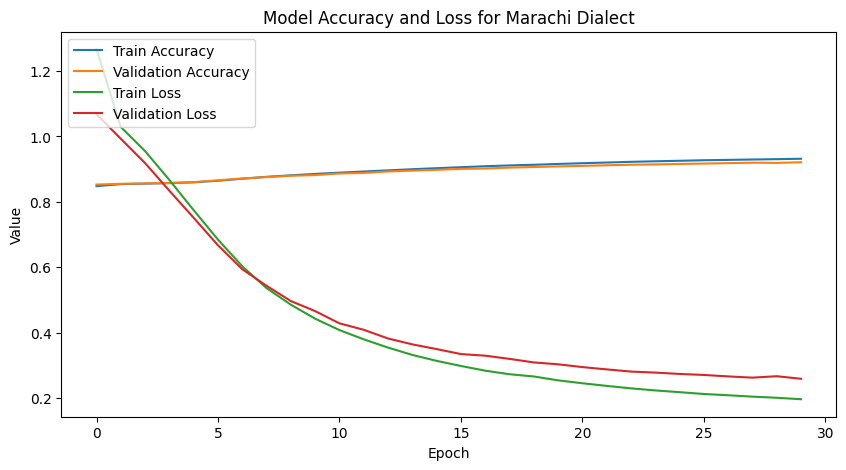

In [22]:
# Plotting the average accuracy and loss
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy values
plt.plot(avg_accuracy, label='Train Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')

# Plot training and validation loss values
plt.plot(avg_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')

# Set the title and labels
plt.title('Model Accuracy and Loss for Marachi Dialect')
plt.ylabel('Value')
plt.xlabel('Epoch')

# Add a legend to distinguish between accuracy and loss
plt.legend(loc='upper left')

# Display the plot
plt.show()

In [17]:
# Print average metrics
print(f'Average accuracy: {np.mean(all_accuracy) * 100:.4f}%')
print(f'Average loss: {np.mean(all_loss) * 100:.4f}')
print(f'Average validation loss: {np.mean(all_val_loss) *100:.4f}')
print(f'Average validation accuracy: {np.mean(all_val_accuracy) * 100:.4f}%')
print(f'Standard deviation of accuracy: {np.std(all_accuracy) * 100:.4f}%')

Average accuracy: 89.8263%
Average loss: 43.3017
Average validation loss: 45.3605
Average validation accuracy: 89.3428%
Standard deviation of accuracy: 2.6685%


In [18]:
# Calculate average metrics across all folds
avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)
avg_accuracy = np.mean(all_accuracy)

In [19]:
print(f'Average Precision: {avg_precision * 100:.4f}%')
print(f'Average Recall: {avg_recall * 100:.4f}%')
print(f'Average F1 Score: {avg_f1 * 100:.4f}')
print(f'Average Accuracy: {avg_accuracy * 100:.4f}%')

Average Precision: 49.0992%
Average Recall: 53.5065%
Average F1 Score: 48.8015
Average Accuracy: 89.8263%


In [43]:
def translation(input_sentence):
    input_sentence = preprocess_text(str(input_sentence))
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq_final = pad_sequences(input_seq,maxlen=max_length,padding="post")
    prediction = model.predict([input_seq_final])
    output_translation = np.argmax(prediction,axis=-1)
    
    output_sentence = []
    for i in output_translation[0]:
        if i in fr_tokenizer.index_word:
            output_sentence.append(fr_tokenizer.index_word[i])
        else:
            output_sentence.append(' ')
    return ' '.join(output_sentence)

In [44]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

##SINGLE WORD INPUTS
import warnings
warnings.filterwarnings('ignore')
# Loop to prompt the user for input three times
for _ in range(3):
    input_sentence = input("Enter a sentence to translate: ")
    translated = translation(input_sentence)
    print(f"Input: {input_sentence}")
    print(f"Translated: {translated}\n")
    
    
    dataset = df

    # Find the corresponding reference translation
    reference_translation = dataset.loc[dataset['Original'] == input_sentence, 'Translation'].values
    if len(reference_translation) > 0:
        reference = reference_translation[0]
    else:
        reference = ""

    # Calculate BLEU score
    reference_tokens = reference.split()
    translated_tokens = translated.split()
    bleu_score = sentence_bleu([reference_tokens], translated_tokens)
    print(f"Reference: {reference}")
    print(f"BLEU Score: {bleu_score:.4f}\n")

Enter a sentence to translate:  ikoras


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Input: ikoras
Translated: kiitikio                                                                                                                                                      

Reference: kiitikio
BLEU Score: 1.0000



Enter a sentence to translate:  oluimbo


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input: oluimbo
Translated: wimbo                                                                                                                                                      

Reference: wimbo
BLEU Score: 1.0000



Enter a sentence to translate:  ingokho


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Input: ingokho
Translated: kuku                                                                                                                                                      

Reference: kuku
BLEU Score: 1.0000



In [45]:
#MULTIPLE WORD INPUTS
import warnings
warnings.filterwarnings('ignore')
# Loop to prompt the user for input three times
for _ in range(3):
    input_sentence = input("Enter a sentence to translate: ")
    translated = translation(input_sentence)
    print(f"Input: {input_sentence}")
    print(f"Translated: {translated}\n")
    
    
    dataset = df

    # Find the corresponding reference translation
    reference_translation = dataset.loc[dataset['Original'] == input_sentence, 'Translation'].values
    if len(reference_translation) > 0:
        reference = reference_translation[0]
    else:
        reference = ""

    # Calculate BLEU score
    reference_tokens = reference.split()
    translated_tokens = translated.split()
    bleu_score = sentence_bleu([reference_tokens], translated_tokens)
    print(f"Reference: {reference}")
    print(f"BLEU Score: {bleu_score:.4f}\n")

Enter a sentence to translate:  isafari eyokhutsia khubebusi bange mombasa


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input: isafari eyokhutsia khubebusi bange mombasa
Translated: ilikuwa ya ya ya wazazi mombasa                                                                                                                                            

Reference: safari ya kuenda kwa wazazi wangu mombasa
BLEU Score: 0.7118



Enter a sentence to translate:  obulwaye bwa korona


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Input: obulwaye bwa korona
Translated: ugonjwa wa korona                                                                                                                                                  

Reference: ugonjwa wa korona
BLEU Score: 1.0000



Enter a sentence to translate:  ngolwa obulwaye buno bwola msialo sia kenya obwera abandu abangi muno


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input: ngolwa obulwaye buno bwola msialo sia kenya obwera abandu abangi muno
Translated: huu ugonjwa ulipofika nchini uliwaua uliwaua wengi wengi sana                                                                                                                                      

Reference: ugonjwa huu ulipofika nchini kenya uliwaua watu wengi sana
BLEU Score: 0.6640



In [46]:
#MULTIPLE WORD INPUTS
import warnings
warnings.filterwarnings('ignore')
# Loop to prompt the user for input three times
for _ in range(3):
    input_sentence = input("Enter a sentence to translate: ")
    translated = translation(input_sentence)
    print(f"Input: {input_sentence}")
    print(f"Translated: {translated}\n")
    
    
    dataset = df
    # Find the corresponding reference translation
    reference_translation = dataset.loc[dataset['Original'] == input_sentence, 'Translation'].values
    if len(reference_translation) > 0:
        reference = reference_translation[0]
    else:
        reference = ""
    # Calculate BLEU score
    reference_tokens = reference.split()
    translated_tokens = translated.split()
    bleu_score = sentence_bleu([reference_tokens], translated_tokens)
    print(f"Reference: {reference}")
    print(f"BLEU Score: {bleu_score:.4f}\n")

Enter a sentence to translate:  mani na vola mbu obulwale bwa korona nebubi sana handi buenyihana vandu vafuale thimasiki nende khuosia mahono vurisiha nende huba ifuti ndala nende inusu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input: mani na vola mbu obulwale bwa korona nebubi sana handi buenyihana vandu vafuale thimasiki nende khuosia mahono vurisiha nende huba ifuti ndala nende inusu
Translated: akasema ni ni wa wa wa kwamba na inatakina inatakina wavae wavae wavae wavae na na na na kuzingztia kuzingztia kusimama kusimama kusimama kutoka kutoka kutoka kutoka                                                                                                  

Reference: akasema kwamba ugonjwa wa korona ni mbaya na inatakina watu wavae barakoa na kunawa mikono kila wakati na kuzingztia kusimama mita moja na nusu kutoka kwa mtu mwingine
BLEU Score: 0.4678



Enter a sentence to translate:  nuahajama noli muisomero huveresianga uvumirifu vunji vulano esie mbolanga mbu njicha khukhulola nikali oli mulamu yoli eyo kata vana vayo valamu vulinyanga


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input: nuahajama noli muisomero huveresianga uvumirifu vunji vulano esie mbolanga mbu njicha khukhulola nikali oli mulamu yoli eyo kata vana vayo valamu vulinyanga
Translated: hivyo nakutia nakutia nakutia nasema nasema nasema nasema kukuona kukuona kukuona huko na na wako wako wako                                                                                                                      

Reference: ukiwa shuleni nakutia moyo sana nami nasema kuwa nitakuja kukuona huko uliko na hata watoto wako ni wazima
BLEU Score: 0.3634



Enter a sentence to translate:  batoto basomanga ingo nende bakukhu babwe hulula mtsingano naye khaandi nambolela isiri indi mbali hale awo ni wali wajama lumarachi walichingi kalibu mwitsa wa vulimundu khubera bandu bali bajama luga lwabu


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input: batoto basomanga ingo nende bakukhu babwe hulula mtsingano naye khaandi nambolela isiri indi mbali hale awo ni wali wajama lumarachi walichingi kalibu mwitsa wa vulimundu khubera bandu bali bajama luga lwabu
Translated: hapo wanasoma wanasoma na na na na na na na siri siri siri siri siri awali awali awali unapenda unapenda unapenda unapenda rafiki rafiki rafiki rafiki                                                                                                    

Reference: watoto walikuwa wanasoma nyumbani na nyanya zao kutoka kwa hadithi na tena akaniambia siri nyingine kuwa hapo awali iwapo ulikuwa unapenda kimarachi ulikwa rafiki wa karibu kila mtu
BLEU Score: 0.6896

